<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/object-detection/3.SignatureDetection.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=blue"></a>
    <a href="https://scaledp.stabrise.com/en/latest/"><img src="https://app.readthedocs.org/projects/scaledp/badge/?version=latest" alt="Documentation Status"/></a>
</p>

# Handwritten Signature Detection with ScaleDP

- Effective reading big pdf files
- Inference using ONNX model for signature detection (no need
PyTorch/TensorFlow installation)


## Installation

In [ ]:
!pip install scaledp

## Start Spark Session with ScaleDP and Spark PDF Data Source

In [ ]:
from scaledp import *

spark = ScaleDPSession(with_spark_pdf=True)
spark

## Read PDF file to the DataFrame

In [6]:
pdf_example = './data/pdfs/SampleWithSignatures.pdf'

df = spark.read.format("pdf") \
    .load(pdf_example)

df.show()

Estimating resolution as 402


+--------------------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+
|                path|            filename|page_number|partition_number|                text|               image|            document|
+--------------------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+
|file:///home/myko...|SampleWithSignatu...|          0|               0| \nhttps://stabri...|{file:///home/myk...|{file:///home/myk...|
+--------------------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+



## Show PDF File as image

Image#:,0
Path:,SampleWithSignatures.pdf
Size:,0 x 0 px
Resolution:,300 dpi

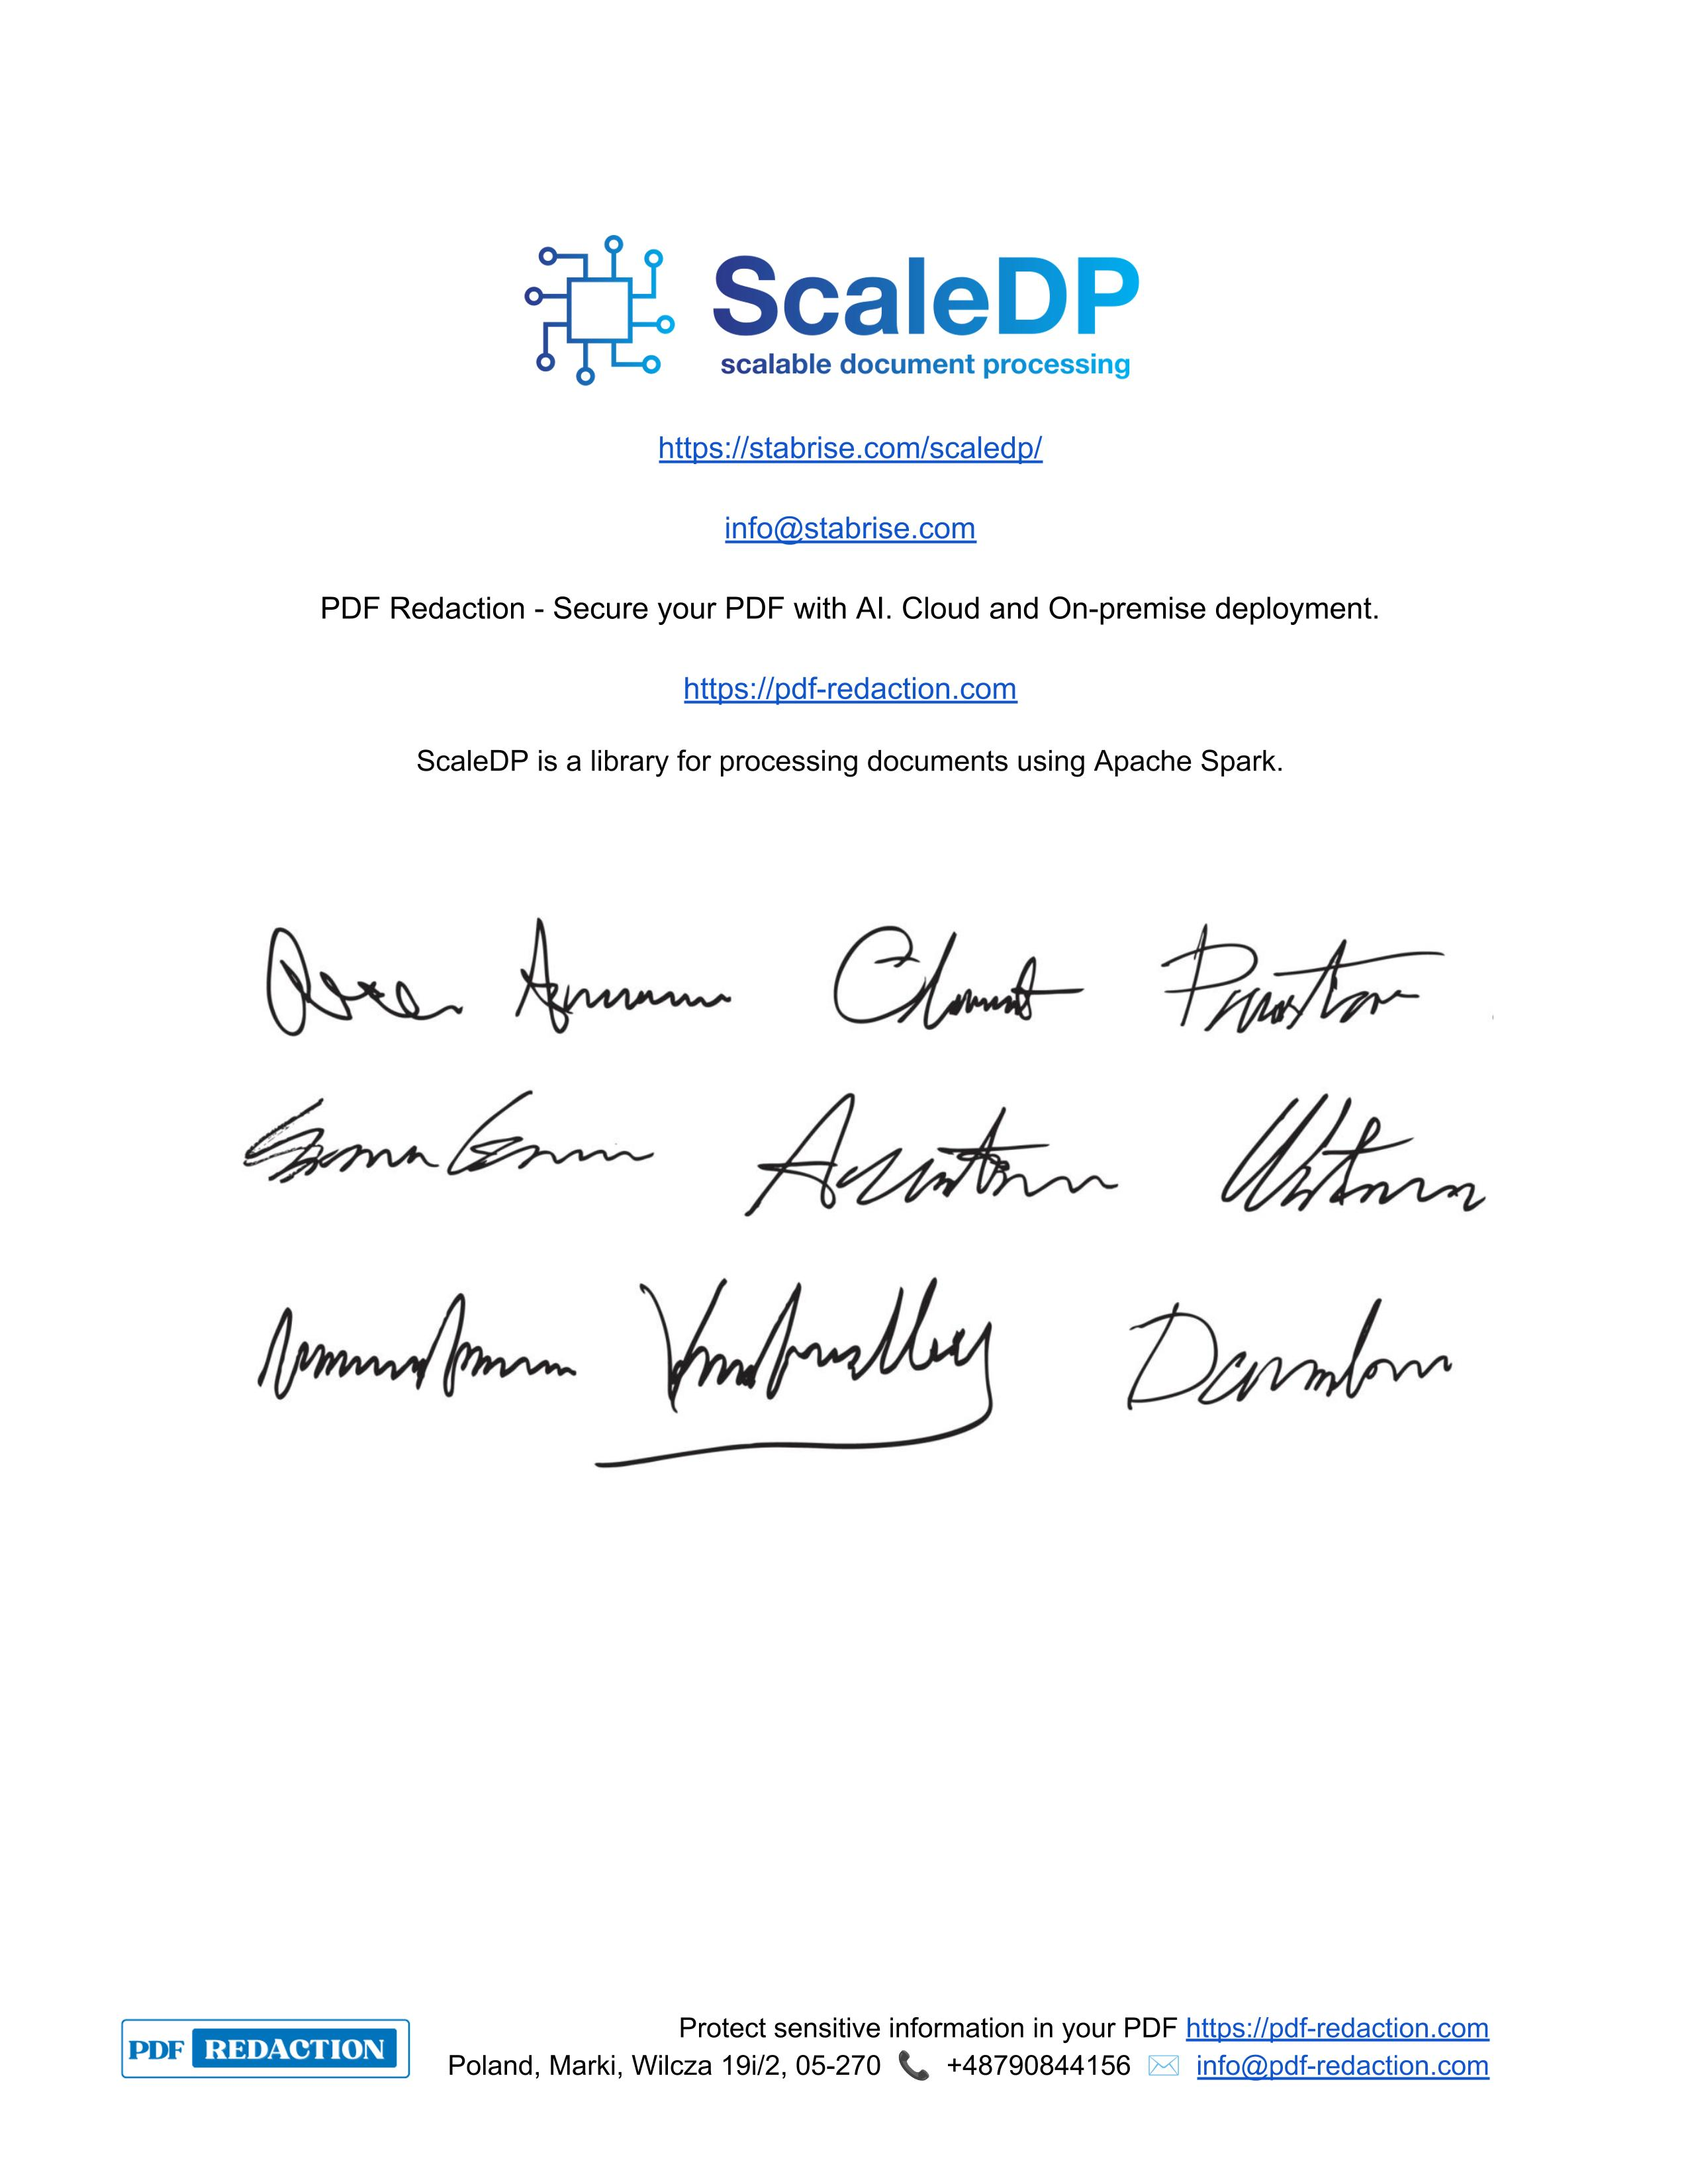

In [7]:
df.show_image()

## Define pipeline for Signature Detection

In [13]:
pipeline = PipelineModel(stages=[
    SignatureDetector(
        keepInputData=True,
        partitionMap=True,
        numPartitions=0,
        task="detect",
    ),
    ImageDrawBoxes(
        keepInputData=True,
        inputCols=["image", "signatures"],
        outputCol="image_with_signatures",
        filled=False,
        color="green",
        lineWidth=5,
    )
])

## Run pipeline and show results dataframe

In [9]:
results = pipeline.transform(df)

results.select("signatures.bboxes").show(1, False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bboxes                                                                                                                                                                                                                                                                                                                          |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{, 0.0, 369, 1339, 776, 244, 

## Explore detected signatures bounding boxes

In [6]:
from pyspark .sql.functions import explode
results.select(explode("signatures.bboxes")).show(10, False)

+----------------------------------+
|col                               |
+----------------------------------+
|{, 0.0, 369, 1339, 776, 244, 0.0} |
|{, 0.0, 352, 1607, 664, 196, 0.0} |
|{, 0.0, 1679, 1936, 555, 208, 0.0}|
|{, 0.0, 1113, 1627, 599, 217, 0.0}|
|{, 0.0, 920, 1887, 618, 335, 0.0} |
|{, 0.0, 347, 1930, 548, 221, 0.0} |
|{, 0.0, 1738, 1362, 462, 209, 0.0}|
|{, 0.0, 1224, 1359, 386, 222, 0.0}|
|{, 0.0, 1816, 1619, 466, 267, 0.0}|
+----------------------------------+



## Display image with detected signatures

Image#:,0
Path:,SampleWithSignatures.pdf
Size:,2550 x 3299 px
Resolution:,300 dpi

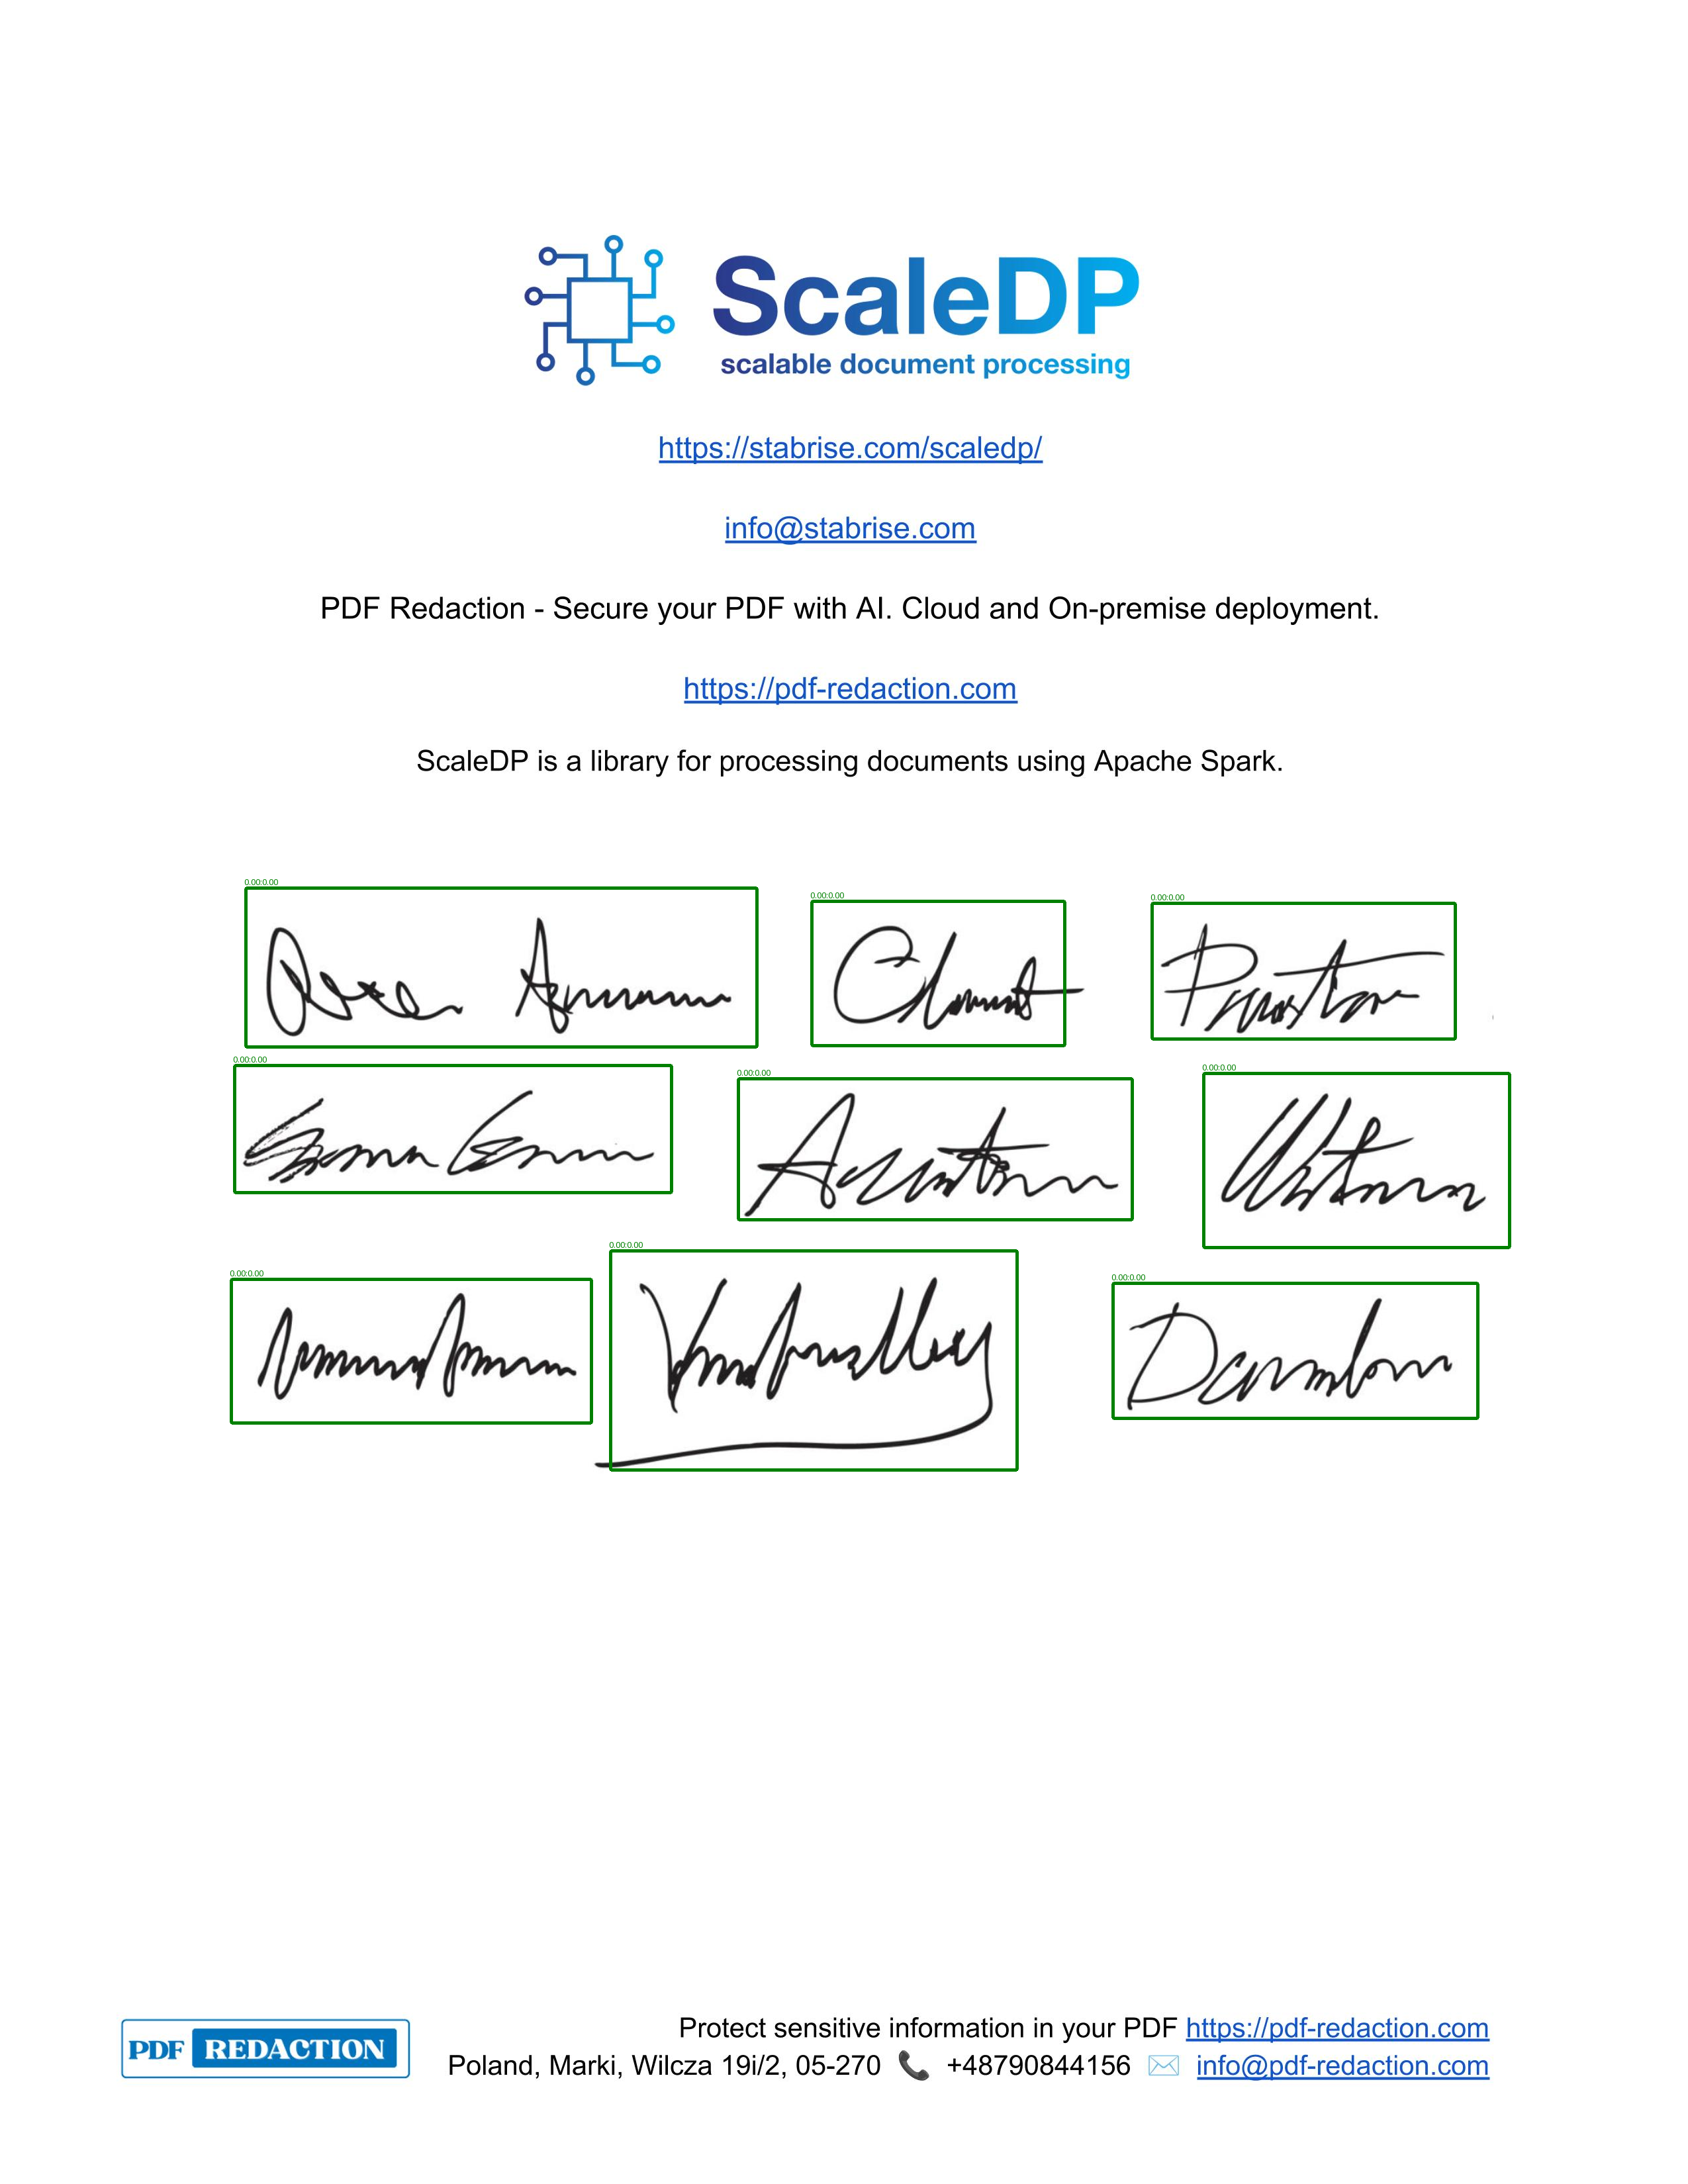

In [10]:
results.show_image("image_with_signatures")

## Crop detected signatures from the image and display them

Estimating resolution as 402


Image#:,0
Path:,SampleWithSignatures.pdf
Size:,776 x 244 px
Resolution:,300 dpi

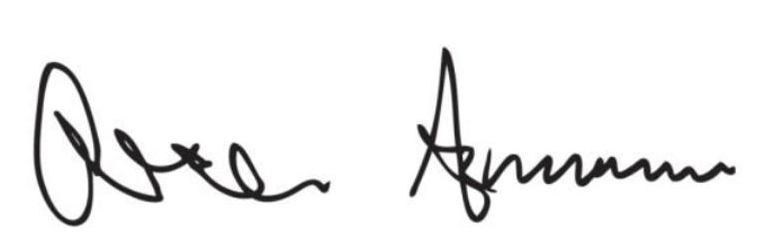

Image#:,1
Path:,SampleWithSignatures.pdf
Size:,664 x 196 px
Resolution:,300 dpi

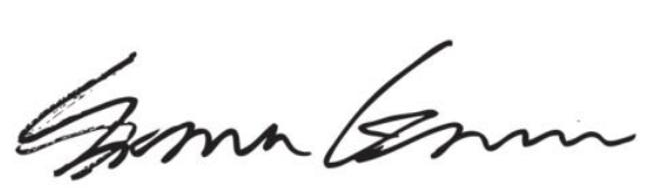

Image#:,2
Path:,SampleWithSignatures.pdf
Size:,555 x 208 px
Resolution:,300 dpi

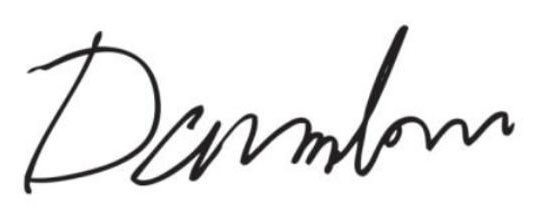

Image#:,3
Path:,SampleWithSignatures.pdf
Size:,599 x 217 px
Resolution:,300 dpi

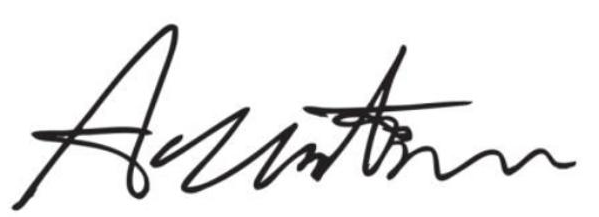

Image#:,4
Path:,SampleWithSignatures.pdf
Size:,618 x 335 px
Resolution:,300 dpi

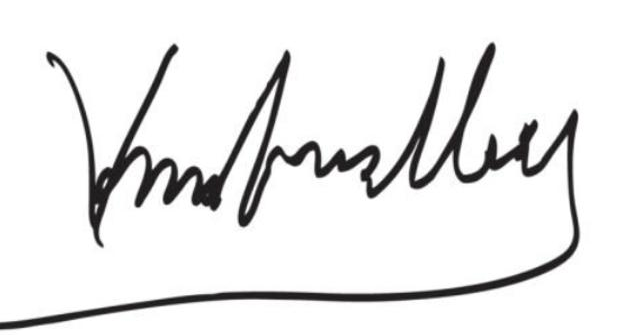

Image#:,5
Path:,SampleWithSignatures.pdf
Size:,548 x 221 px
Resolution:,300 dpi

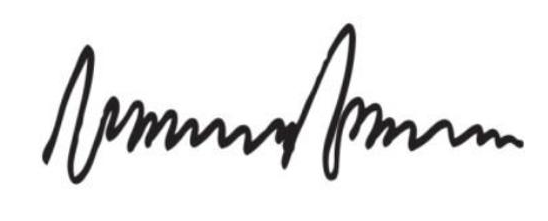

Image#:,6
Path:,SampleWithSignatures.pdf
Size:,462 x 209 px
Resolution:,300 dpi

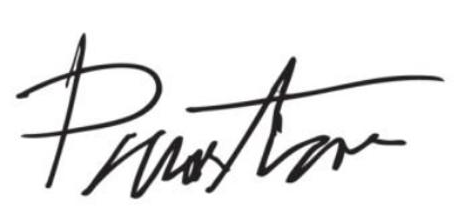

Image#:,7
Path:,SampleWithSignatures.pdf
Size:,386 x 222 px
Resolution:,300 dpi

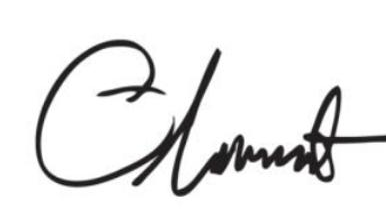

Image#:,8
Path:,SampleWithSignatures.pdf
Size:,466 x 267 px
Resolution:,300 dpi

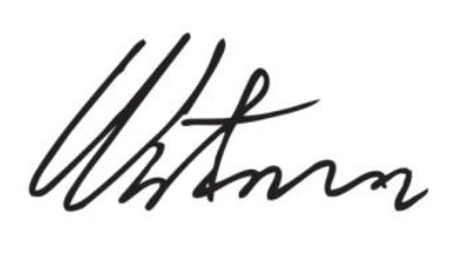

In [12]:
result_croped = ImageCropBoxes(inputCols=["image", "signatures"]) \
    .transform(results) \
    .cache()
result_croped.show_image("cropped_image", limit=10, width=200)